In [16]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

In [17]:
#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

In [18]:
import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

In [19]:
import pytz

import pickle

In [6]:
!pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [20]:
import shap

In [21]:
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

In [32]:
RANDOM_STATE = 42

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def loss_functions(y_true, y_pred):
    print("Loss functions:")
    print("* R-squared =", r2_score(y_true, y_pred))
    print("* RMSE =", mean_squared_error(y_true, y_pred))
    print("* MAE =", mean_absolute_error(y_true, y_pred))

### Read Data
 https://github.com/yichigo/Light-Sensors-Calibration/blob/master/model_MLP_whole.ipynb

In [23]:
df=pd.read_csv(r"C:\\Users\\bkari\\Desktop\\complete_data.csv")

In [24]:
df.head(2)

,Unnamed: 0,RefSt,Sensor,Gewicht,Raw_Feucht,Temp_grain,SommerDurumweizen,SommerGerste,Weizen,WinterDurumweizen,WinterGerste,WinterRaps,WinterRoggen,WinterTriticale,WinterWeizen
0,0,13.33,13.0,8.07,1214.0,40.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,14.17,13.3,6.96,1292.0,40.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df=df.iloc[:,1:]

In [26]:
df.head(2)

,RefSt,Sensor,Gewicht,Raw_Feucht,Temp_grain,SommerDurumweizen,SommerGerste,Weizen,WinterDurumweizen,WinterGerste,WinterRaps,WinterRoggen,WinterTriticale,WinterWeizen
0,13.33,13.0,8.07,1214.0,40.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.17,13.3,6.96,1292.0,40.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df.columns

Index(['RefSt', 'Sensor', 'Gewicht', 'Raw_Feucht', 'Temp_grain',
       'SommerDurumweizen', 'SommerGerste', 'Weizen', 'WinterDurumweizen',
       'WinterGerste', 'WinterRaps', 'WinterRoggen', 'WinterTriticale',
       'WinterWeizen'],
      dtype='object')

In [28]:
features=df[['Sensor', 'Gewicht', 'Raw_Feucht', 'Temp_grain', 'SommerDurumweizen', 'SommerGerste', 'Weizen', 'WinterDurumweizen',
             'WinterGerste', 'WinterRaps', 'WinterRoggen', 'WinterTriticale', 'WinterWeizen']]

X=features

In [29]:
targets=df[['RefSt']]
Y=targets

### Split the Data (Prepare Data For Training)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# scale the data
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

In [34]:
# try PCA
pca1 = PCA(n_components=13, random_state = RANDOM_STATE)
X_temp = pca1.fit_transform(X_train_scaled[:,:])
print(pca1.explained_variance_)

[2.47864708e+00 1.53953077e+00 1.48168945e+00 1.22221797e+00
 1.12846318e+00 1.08748765e+00 1.06303589e+00 1.02042986e+00
 8.35507875e-01 6.36663502e-01 4.98803549e-01 9.49322965e-03
 1.46898305e-31]


In [35]:
# PCA
n_components = 13

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_scaled_DR = pca.fit_transform(X_train_scaled)
X_test_scaled_DR = pca.transform(X_test_scaled)

X_train_scaled_DR = pd.DataFrame(X_train_scaled_DR)
X_test_scaled_DR = pd.DataFrame(X_test_scaled_DR)
print(pca.explained_variance_)

# save pca model
dir_DR = '../models/'
if not os.path.exists(dir_DR):
    os.mkdir(dir_DR)

fn_DR = dir_DR + DR + '.sav'
pickle.dump(pca, open(fn_DR, 'wb'))

[2.47864708e+00 1.53953077e+00 1.48168945e+00 1.22221797e+00
 1.12846318e+00 1.08748765e+00 1.06303589e+00 1.02042986e+00
 8.35507875e-01 6.36663502e-01 4.98803549e-01 9.49322965e-03
 1.46898305e-31]


In [36]:
# scale the data again before NN
scaler_x2 = StandardScaler()
X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

### Model Start from here

In [298]:
hidden_layer_sizes=(64,128,256)

activation ='relu'
solver = 'adam'
alpha=1e-4 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'adaptive'
early_stopping = True
tol = 1e-4
n_iter_no_change = 10


# include layer structure and activation function
if type(hidden_layer_sizes) == int: # single-layer case
    hidden_layer_sizes_string = str(hidden_layer_sizes)
else: # multi-layers case
    hidden_layer_sizes_string = str(hidden_layer_sizes)[1:-1].replace(', ','_')

structure = '_' + DR + str(n_components) + \
            '_' + hidden_layer_sizes_string + \
            '_' + activation

In [299]:
start_time = time.time()

regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True,
                    early_stopping = early_stopping,
                    tol = tol,
                    momentum=0.9,
                    n_iter_no_change = n_iter_no_change
                    )
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

print("--- %s seconds ---" % (time.time() - start_time))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Iteration 1, loss = 0.18794174
Validation score: 0.810153
Iteration 2, loss = 0.10551911
Validation score: 0.826598
Iteration 3, loss = 0.09374574
Validation score: 0.838840
Iteration 4, loss = 0.08721738
Validation score: 0.844194
Iteration 5, loss = 0.08240517
Validation score: 0.852330
Iteration 6, loss = 0.07813900
Validation score: 0.855814
Iteration 7, loss = 0.07829939
Validation score: 0.848655
Iteration 8, loss = 0.07509388
Validation score: 0.861179
Iteration 9, loss = 0.07512654
Validation score: 0.862718
Iteration 10, loss = 0.07216787
Validation score: 0.866856
Iteration 11, loss = 0.07039919
Validation score: 0.869984
Iteration 12, loss = 0.06741375
Validation score: 0.869292
Iteration 13, loss = 0.06697429
Validation score: 0.864959
Iteration 14, loss = 0.06592583
Validation score: 0.865913
Iteration 15, loss = 0.06533192
Validation score: 0.867571
Iteration 16, loss = 0.06411969
Validation score: 0.877207
Iteration 17, loss = 0.06269562
Validation score: 0.872712
Iterat

In [300]:
regr.warm_start = True
regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

Iteration 36, loss = 0.05527303


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Validation score: 0.901332
Iteration 37, loss = 0.05457577
Validation score: 0.901159
Iteration 38, loss = 0.05430844
Validation score: 0.900148
Iteration 39, loss = 0.05407374
Validation score: 0.900927
Iteration 40, loss = 0.05397862
Validation score: 0.900267
Iteration 41, loss = 0.05386562
Validation score: 0.899641
Iteration 42, loss = 0.05358505
Validation score: 0.899764
Iteration 43, loss = 0.05379475
Validation score: 0.899834
Iteration 44, loss = 0.05350182
Validation score: 0.899590
Iteration 45, loss = 0.05340962
Validation score: 0.899732
Iteration 46, loss = 0.05326290
Validation score: 0.899620
Iteration 47, loss = 0.05326909
Validation score: 0.900050
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(early_stopping=True, hidden_layer_sizes=(64, 128, 256),
             learning_rate='adaptive', learning_rate_init=0.0001,
             random_state=42, verbose=True, warm_start=True)

In [301]:
from sklearn.metrics import r2_score

Y_train_pred = scaler_y.inverse_transform(
    regr.predict( X_train_scaled_DR_scaled )
) # for train
# Y_train_pred = regr.predict( X_train_scaled_DR_scaled ) # for train
train_score = r2_score(Y_train, Y_train_pred)

Y_test_pred = scaler_y.inverse_transform(
    regr.predict( X_test_scaled_DR_scaled )
)# for test
# Y_test_pred = regr.predict( X_test_scaled_DR_scaled )# for test
test_score = r2_score(Y_test, Y_test_pred)

In [302]:
print(test_score)
print(train_score)

0.8131231552779805
0.8902561470416266


In [278]:
df_temp = pd.DataFrame({'Actual': Y_test['RefSt'], 'Predicted': Y_test_pred})
df_temp.head()

,Actual,Predicted
8222,12.46,12.313740
4832,11.42,11.660157
1817,11.74,12.088886
5663,12.67,12.568419
6488,18.41,15.416769


In [308]:
loss_functions(Y_test,Y_test_pred)

Loss functions:
* R-squared = 0.8131231552779805
* RMSE = 0.6202124233085671
* MAE = 0.5048784635662016


In [313]:
#Normalised RMSE
0.62/max(df['RefSt']-min(df['RefSt']))

0.029439696106362774

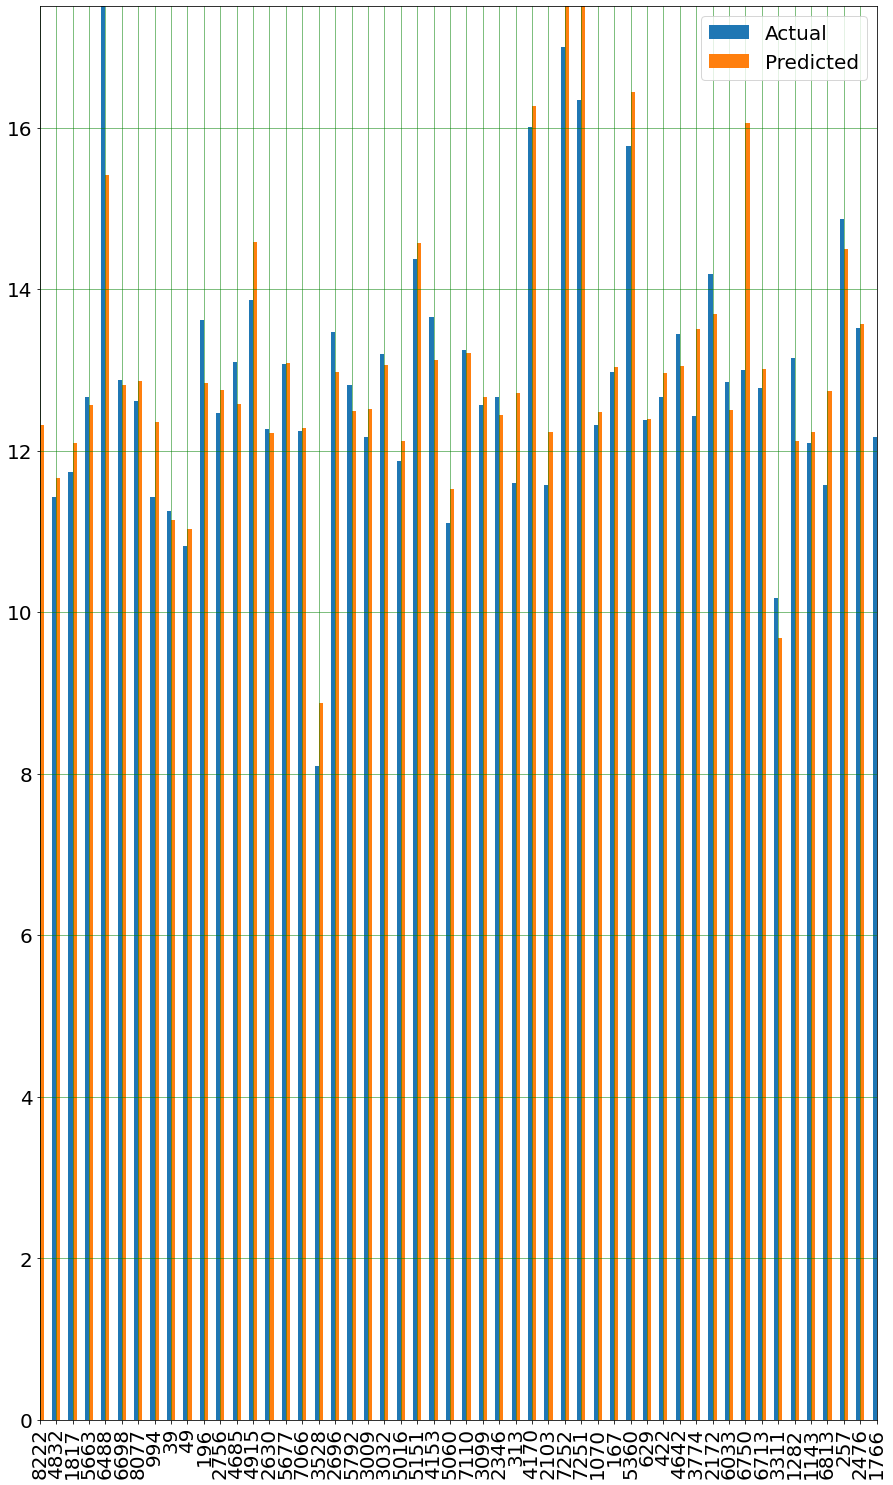

Loss functions:
* R-squared = 0.8131231552779805
* RMSE = 0.6202124233085671
* MAE = 0.5048784635662016


In [304]:
#This is the actual. vs. predicted

f_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(15,26))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlim(0,51)
plt.ylim(0,17.5)
plt.show()

loss_functions(Y_test,Y_test_pred)

In [284]:
# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)


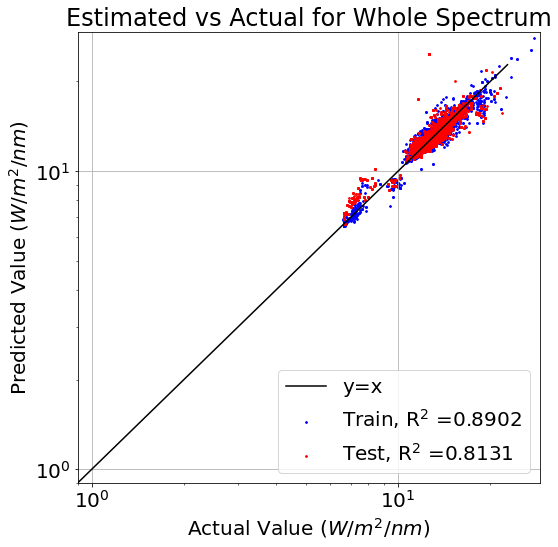

In [305]:
plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
id_train = np.random.choice(len(Y_train_flatten), 5000, replace = True)
plt.scatter(Y_train_flatten[id_train], Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])

id_test = np.random.choice(len(Y_test_flatten), 5000, replace = True)
plt.scatter(Y_test_flatten[id_test], Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])

plt.xlim(9E-1, )
plt.ylim(9E-1, )


ax.set_title('Estimated vs Actual for Whole Spectrum')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Predicted Value $(W/m^2/nm)$')
plt.xscale('log')
plt.yscale('log')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

In [306]:
Y_train_flatten_sorted = np.sort(Y_train_flatten)
Y_train_pred_flatten_sorted = np.sort(Y_train_pred_flatten)

Y_test_flatten_sorted = np.sort(Y_test_flatten)
Y_test_pred_flatten_sorted = np.sort(Y_test_pred_flatten)

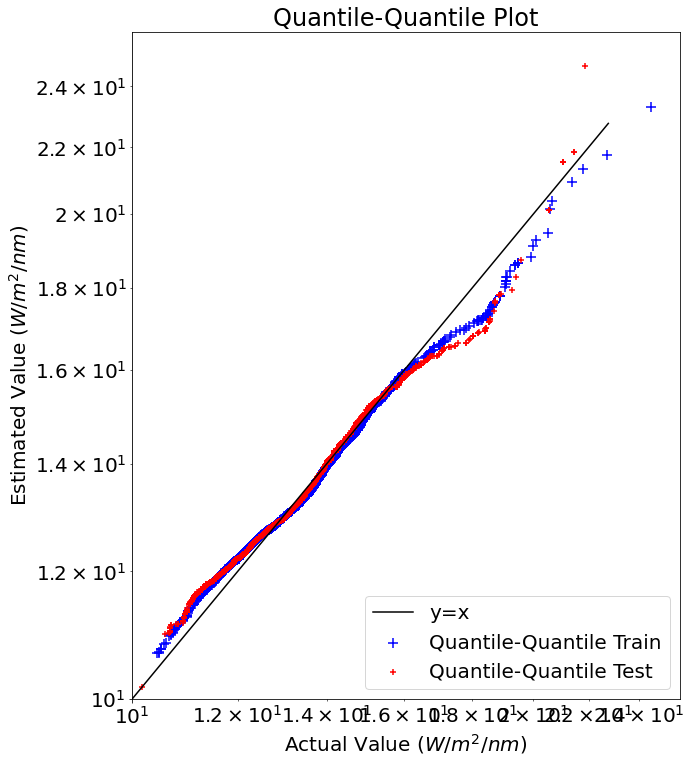

In [307]:
Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)
y_line = np.linspace(Y_min,Y_max,100)


plt.rcParams["figure.figsize"] = (10, 11) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten_sorted), 2000, replace = True)
plt.scatter(Y_train_flatten_sorted[id_train], Y_train_pred_flatten_sorted[id_train], s=100, c = 'blue',
            marker = '+', label = 'Quantile-Quantile Train')

id_test = np.random.choice(len(Y_test_flatten_sorted), 2000, replace = True)
plt.scatter(Y_test_flatten_sorted[id_test], Y_test_pred_flatten_sorted[id_test], s=30, c = 'red',
            marker = '+', label = 'Quantile-Quantile Test')
plt.xlim(10E0, )
plt.ylim(10E0, )

# x_25 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4]
# y_25 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4]
# x_50 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//2]
# y_50 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//2]
# x_75 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4*3]
# y_75 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4*3]
# plt.text(x_25, y_25, '25', c ='blue', ha = 'center', va = 'center')
# plt.text(x_50, y_50, '50', c ='blue', ha = 'center', va = 'center')
# plt.text(x_75, y_75, '75', c ='blue', ha = 'center', va = 'center')

ax.set_title('Quantile-Quantile Plot')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Estimated Value $(W/m^2/nm)$')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend( loc='lower right')

plt.tight_layout()

In [158]:
# Create object that can calculate shap values
num_shap = 200
explainer = shap.KernelExplainer(regr.predict, X_train_scaled_DR_scaled[:num_shap])
# Calculate shap_values
shap_values_multi_DR_Yscaled = explainer.shap_values(X_train_scaled_DR_scaled[:num_shap]) # 421 x num_shap x n_components

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [172]:
shap_values_multi_DR_Yscaled

array([[ 0.75239488,  0.14656145, -0.00629298, ..., -0.04264576,
         0.00527072,  1.06856562],
       [-1.27271479,  0.00968771,  0.30035708, ..., -0.25803699,
        -0.34582446,  1.16131936],
       [ 0.01563886,  0.00945226,  0.16613016, ...,  0.45186011,
        -0.08560002,  0.23931635],
       ...,
       [-0.68929429,  0.10565808, -0.0078058 , ..., -0.08945897,
        -0.01647077, -0.01115132],
       [-0.23929881, -0.00375846, -0.03445733, ..., -0.00704719,
        -0.00492244, -0.00418665],
       [ 0.22795583,  0.18283569,  0.06911658, ..., -0.03750922,
         0.06344282,  0.00334783]])

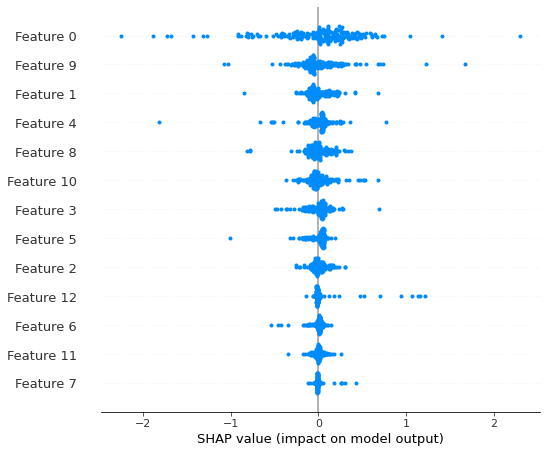

In [183]:
shap.summary_plot(shap_values_multi_DR_Yscaled)

In [184]:
import matplotlib as mpl
import matplotlib.cm as cm

importances_DR = np.mean(np.abs(shap_values_DR_Yscaled), axis = 0)
indices = np.argsort(importances_DR)

# color positive/negative impact blue/red
colormap = {1:'red',-1:'blue', 0:'grey'}
impacts = np.array([])
corrcoef = np.array([])
sign = np.array([])
for i in range(n_components):
    impact_i = (shap_values_DR[:,i]*np.sign(X_train_scaled_DR_scaled[:num_shap,i] - X_train_scaled_DR_scaled[:num_shap, i].mean() )).mean()
    impacts = np.append(impacts, impact_i)

    corrcoef_i = np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_pred.mean(axis = 1))[0,1]
    corrcoef = np.append(corrcoef, corrcoef_i)

    sign_i = np.sign(corrcoef_i)
    sign = np.append(sign, sign_i)

sign = sign[indices]
impacts = impacts[indices]
corrcoef = corrcoef[indices]

# norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
cmap = cm.get_cmap('RdBu_r')
m = cm.ScalarMappable(norm=norm, cmap=cmap)

color = [colormap[val] for val in sign]
# color = [m.to_rgba(val) for val in impacts]
# color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(shap_values_DR, X_train_scaled_DR_scaled[:num_shap],
                  feature_names = ['PC ' + str(i) for i in range(num_features)],
                  plot_size=(8,max_display/2.5),#'auto'
                  color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                  )

plt.xscale("log")
plt.title(DR + ' Feature Importances for Whole Spectrum', fontsize = 20)
plt.tight_layout()

### Ridge Regression

In [324]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

In [361]:
model = Ridge(alpha=1.0)

In [326]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [328]:
scores = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [329]:
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.694 (0.025)


In [331]:
cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=1)

In [333]:
model.fit(X_train, Y_train)

Ridge()

In [334]:
yhat = model.predict(X_test)

In [335]:
yhat

array([[12.59637813],
       [11.58261285],
       [11.88824719],
       ...,
       [15.94594955],
       [11.78361031],
       [13.21787817]])

In [336]:
Y_test

,RefSt
8222,12.46
4832,11.42
1817,11.74
5663,12.67
6488,18.41
...,...
1718,12.57
6694,13.17
5609,15.80
1292,12.31


In [337]:
loss_functions(yhat,Y_test)

Loss functions:
* R-squared = 0.6006895919219286
* RMSE = 1.0151793448697986
* MAE = 0.6778548330822047


In [349]:
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='r2', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, Y_train)
# summarize
print('R2: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

R2: 0.734
Config: {'alpha': 0.01}


In [353]:
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, Y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.693
Config: {'alpha': 0.01}


In [356]:
# use automatically configured the ridge regression algorithm

from sklearn.linear_model import RidgeCV
model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
# fit model
model.fit(X_train, Y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

Ill-conditioned matrix (rcond=1.30744e-22): result may not be accurate.
Ill-conditioned matrix (rcond=1.78444e-23): result may not be accurate.
Ill-conditioned matrix (rcond=5.78205e-22): result may not be accurate.
Ill-conditioned matrix (rcond=7.16497e-22): result may not be accurate.
Ill-conditioned matrix (rcond=1.03631e-21): result may not be accurate.
Ill-conditioned matrix (rcond=8.78515e-22): result may not be accurate.
Ill-conditioned matrix (rcond=8.37379e-22): result may not be accurate.
Ill-conditioned matrix (rcond=3.20755e-22): result may not be accurate.
Ill-conditioned matrix (rcond=7.26325e-22): result may not be accurate.
Ill-conditioned matrix (rcond=6.84487e-22): result may not be accurate.
Ill-conditioned matrix (rcond=5.26821e-22): result may not be accurate.
Ill-conditioned matrix (rcond=1.32848e-21): result may not be accurate.


alpha: 0.010000


In [358]:
yhat = model.predict(X_test)

In [363]:
# once again for my choosed parameters
model=Ridge(alpha=0.01)
model.fit(X_train,Y_train)
yhat=model.predict(X_test)
loss_functions(yhat,Y_test)

Loss functions:
* R-squared = 0.6038577683014202
* RMSE = 1.009122882935659
* MAE = 0.6772208250770999



### Gaussian Process Regression

In [64]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.model_selection import KFold

In [56]:
kernel = DotProduct() + WhiteKernel() + 10 * RBF(1, (1e-2, 1e2))

In [57]:
from sklearn.gaussian_process import GaussianProcessRegressor
regressor = GaussianProcessRegressor(kernel=kernel)

In [58]:
regressor.fit(X_train_scaled_DR_scaled, Y_train_scaled)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1) + 3.16**2 * RBF(length_scale=1))

In [59]:
y_hat=regressor.predict(X_test_scaled_DR_scaled)

In [60]:
loss_functions(y_hat,Y_test_scaled)

Loss functions:
* R-squared = 0.7884638185309023
* RMSE = 0.1624469538984776
* MAE = 0.26071810129729733


In [65]:

gp = GaussianProcessRegressor(kernel=kernel)
parameters = {'alpha':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
cv_obj = KFold(n_splits=5)
regr = GridSearchCV(gp,parameters,cv=cv_obj,n_jobs=8,refit=True)
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)
print(regr.best_estimator_)

GaussianProcessRegressor(alpha=0.0001,
                         kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1) + 3.16**2 * RBF(length_scale=1))


In [69]:
y_hat=regr.predict(X_test_scaled_DR_scaled)

In [70]:
loss_functions(y_hat,Y_test_scaled)

Loss functions:
* R-squared = 0.7884638701904878
* RMSE = 0.16244694887914635
* MAE = 0.26071768475451923


In [71]:
#Now try with the above CV
regressor = GaussianProcessRegressor(alpha=0.0001,
                                     kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1) + 3.16**2 * RBF(length_scale=1))


In [72]:
regressor.fit(X_train_scaled_DR_scaled, Y_train_scaled)
y_hat=regressor.predict(X_test_scaled_DR_scaled)

In [73]:
loss_functions(y_hat,Y_test_scaled)

Loss functions:
* R-squared = 0.7884637972677501
* RMSE = 0.16244697592140261
* MAE = 0.2607181036588773
